In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time

import matplotlib.pyplot as plt
import numpy as np
import proper

from paos.core.parseConfig import parse_config
from paos.core.run import run

In [3]:
def extent(wfarr, dx, dy):
    return (-wfarr.shape[1] // 2 * dx, (wfarr.shape[1] // 2 - 1) * dx,
            -wfarr.shape[0] // 2 * dy, (wfarr.shape[0] // 2 - 1) * dy)


def push_results(wfo, init=False):
    if init:
        fratio = proper.prop_get_fratio(wfo)
        retval = {'fratio': fratio if fratio < 1e9 else np.inf}
    else:
        fratio = proper.prop_get_fratio(wfo)
        retval = {'amplitude': proper.prop_get_amplitude(wfo),
                  'wz': proper.prop_get_beamradius(wfo),
                  'distancetofocus': proper.prop_get_distancetofocus(wfo),
                  'phase': proper.prop_get_phase(wfo),  # phase angles in proper are defined in the opposite sense
                  'dx': proper.prop_get_sampling(wfo),
                  'dy': proper.prop_get_sampling(wfo),
                  'wfo': proper.prop_get_wavefront(wfo),
                  'wl': proper.prop_get_wavelength(wfo),
                  'aperture': None,
                  'fratio': fratio if fratio < 1e9 else np.inf
                  }
        retval['extent'] = extent(retval['wfo'], retval['dx'], retval['dy'])
    return retval

In [4]:
def template(wl, gridsize, PASSVALUE=None):
    if PASSVALUE is None:
        PASSVALUE = {}
    proper.print_it = True

    start_time = time.time()

    # Define entrance aperture diameter and other quantities
    diam = 1.0  # telescope diameter in meters
    fl_pri = 1.0  # primary focal length (m)
    d_pri_to_focus = 1.0  # distance from primary to focus
    beam_ratio = 0.25  # initial beam width/grid width

    # Define the wavefront
    wfo = proper.prop_begin(diam, wl, gridsize, beam_ratio)
    proper.prop_set_antialiasing(nsub=101)

    # Define a circular aperture
    proper.prop_circular_aperture(wfo, diam / 2)  # aperture (primary mirror)

    # Define entrance
    proper.prop_define_entrance(wfo)

    # Define a lens
    PASSVALUE[0] = push_results(wfo, init=True)
    proper.prop_lens(wfo, fl_pri, "primary")  # primary mirror
    PASSVALUE[0].update(push_results(wfo))

    PASSVALUE[1] = push_results(wfo)
    proper.prop_propagate(wfo, d_pri_to_focus, "focus", TO_PLANE=False)
    PASSVALUE[1].update(push_results(wfo))

    # End
    (wfo, sampling) = proper.prop_end(wfo)

    end_time = time.time()

    if proper.print_it:
        print("Total elapsed time (seconds) = %8.4f" % (end_time - start_time))

    return PASSVALUE

## Validation

# Super simple model

## PAOS

In [5]:
pup_diameter, parameters, wavelengths, fields, opt_chains = parse_config('../template.ini')
wavelength, opt_chain = wavelengths[0], opt_chains[0]
retval_paos = run(pup_diameter, 1.0e-6 * wavelength, parameters['grid_size'], parameters['zoom'], fields[0], opt_chain)
paos_key = list(retval_paos.keys())[-1]  # plot at last optical surface
paos_item = retval_paos[paos_key]

## Proper

In [6]:
retval_proper = template(wl=1.1e-6, gridsize=1024, PASSVALUE={})
proper_key = list(retval_proper.keys())[-1]  # plot at last optical surface
proper_item = retval_proper[proper_key]

Applying lens at primary
Propagating to focus
Total elapsed time (seconds) =   0.8219


In [7]:
proper_phase = proper_item['phase']
paos_phase = paos_item['phase']

proper_amplitude = proper_item['amplitude']
paos_amplitude = paos_item['amplitude']

proper_psf = proper_amplitude ** 2
paos_psf = paos_amplitude ** 2

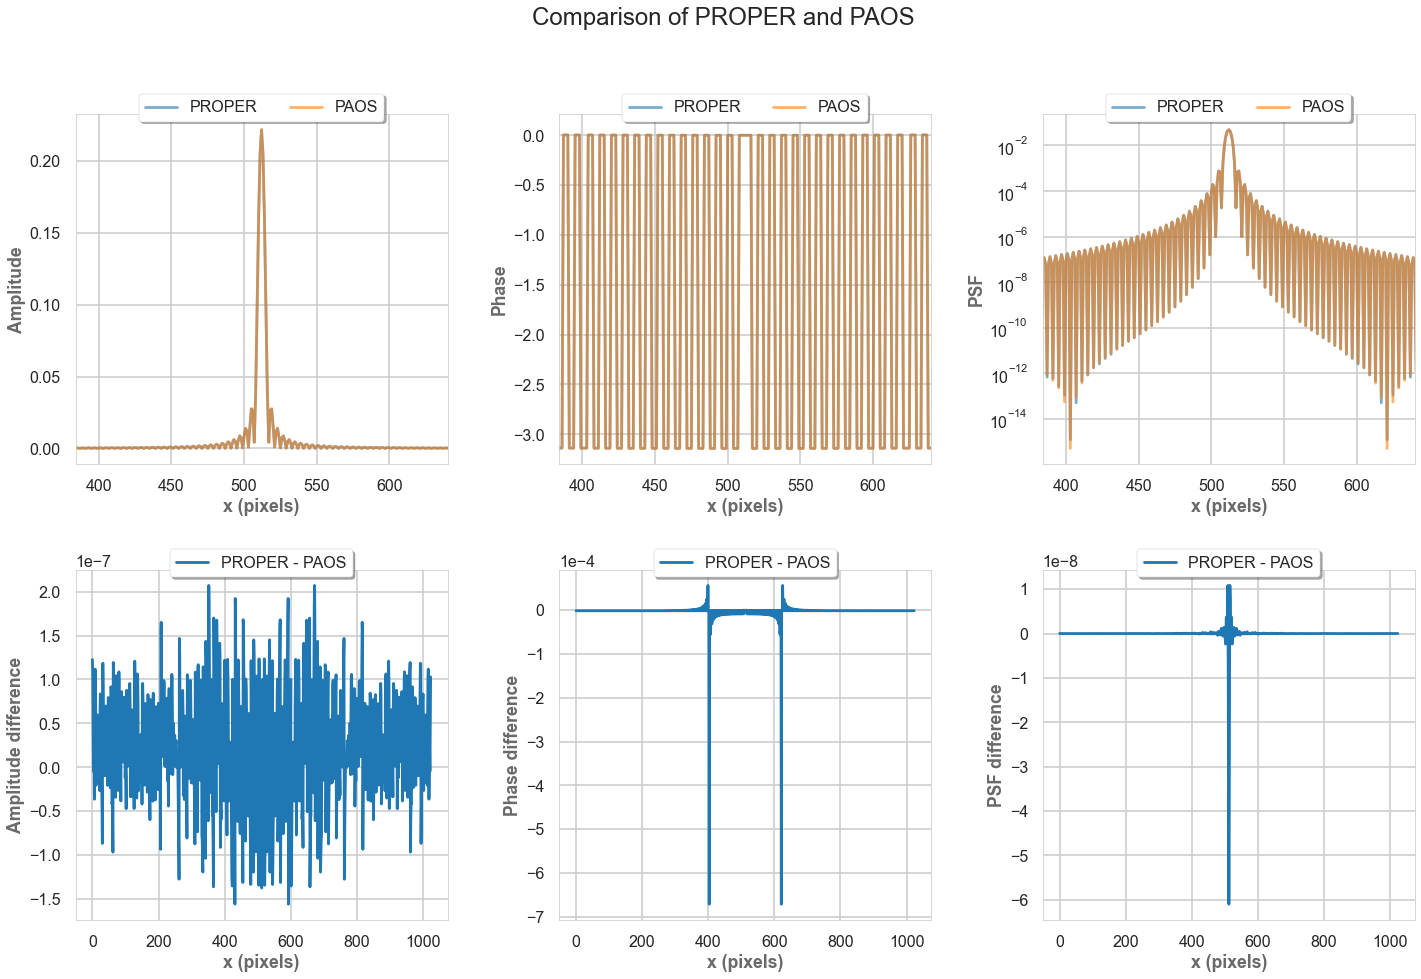

In [8]:
plt.style.use('seaborn-poster')
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(24, 24 / 1.618))
plt.subplots_adjust(wspace=0.3, hspace=0.3)
fig.suptitle('Comparison of PROPER and PAOS', fontsize=24)

ax = ax.flatten()
ax[0].plot(proper_amplitude[proper_amplitude.shape[0] // 2, :], label='PROPER', alpha=0.6)
ax[0].plot(paos_amplitude[paos_amplitude.shape[0] // 2, :], label='PAOS', alpha=0.6)
ax[0].set_xlim(1024 // 2 - 128, 1024 // 2 + 128)
# Put the legend just above the plot
ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.08),
             ncol=3, fancybox=True, shadow=True)
ax[0].set_xlabel('x (pixels)')
ax[0].set_ylabel('Amplitude')

ax[1].plot(proper_phase[proper_phase.shape[0] // 2, :], label='PROPER', alpha=0.6)
ax[1].plot(paos_phase[paos_phase.shape[0] // 2, :], label='PAOS', alpha=0.6)
ax[1].set_xlim(1024 // 2 - 128, 1024 // 2 + 128)
ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.08),
             ncol=3, fancybox=True, shadow=True)
ax[1].set_xlabel('x (pixels)')
ax[1].set_ylabel('Phase')

ax[2].semilogy(proper_psf[proper_psf.shape[0] // 2, :], label='PROPER', alpha=0.6)
ax[2].semilogy(paos_psf[paos_psf.shape[0] // 2, :], label='PAOS', alpha=0.6)
ax[2].set_xlim(1024 // 2 - 128, 1024 // 2 + 128)
ax[2].legend(loc='upper center', bbox_to_anchor=(0.5, 1.08),
             ncol=3, fancybox=True, shadow=True)
ax[2].set_xlabel('x (pixels)')
ax[2].set_ylabel('PSF')

ax[3].plot(proper_amplitude[proper_amplitude.shape[0] // 2, :] - paos_amplitude[paos_amplitude.shape[0] // 2, :], label='PROPER - PAOS')
# ax[3].set_xlim(1024 // 2 - 128, 1024 // 2 + 128)
ax[3].legend(loc='upper center', bbox_to_anchor=(0.5, 1.08),
             ncol=3, fancybox=True, shadow=True)
ax[3].set_xlabel('x (pixels)')
ax[3].set_ylabel('Amplitude difference')


ax[4].plot(proper_phase[proper_phase.shape[0] // 2, :] - paos_phase[paos_phase.shape[0] // 2, :], label='PROPER - PAOS')
# ax[4].set_xlim(1024 // 2 - 128, 1024 // 2 + 128)
# Enforce scientific notation
ax[4].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
ax[4].legend(loc='upper center', bbox_to_anchor=(0.5, 1.08),
             ncol=3, fancybox=True, shadow=True)
ax[4].set_xlabel('x (pixels)')
ax[4].set_ylabel('Phase difference')

ax[5].plot(proper_psf[proper_psf.shape[0] // 2, :] - paos_psf[paos_psf.shape[0] // 2, :], label='PROPER - PAOS')
# ax[5].set_xlim(1024 // 2 - 128, 1024 // 2 + 128)
ax[5].legend(loc='upper center', bbox_to_anchor=(0.5, 1.08),
             ncol=3, fancybox=True, shadow=True)
ax[5].set_xlabel('x (pixels)')
ax[5].set_ylabel('PSF difference')

plt.show()
# plt.savefig('figures/compare_proper_paos.pdf', dpi=300, bbox_inches='tight')

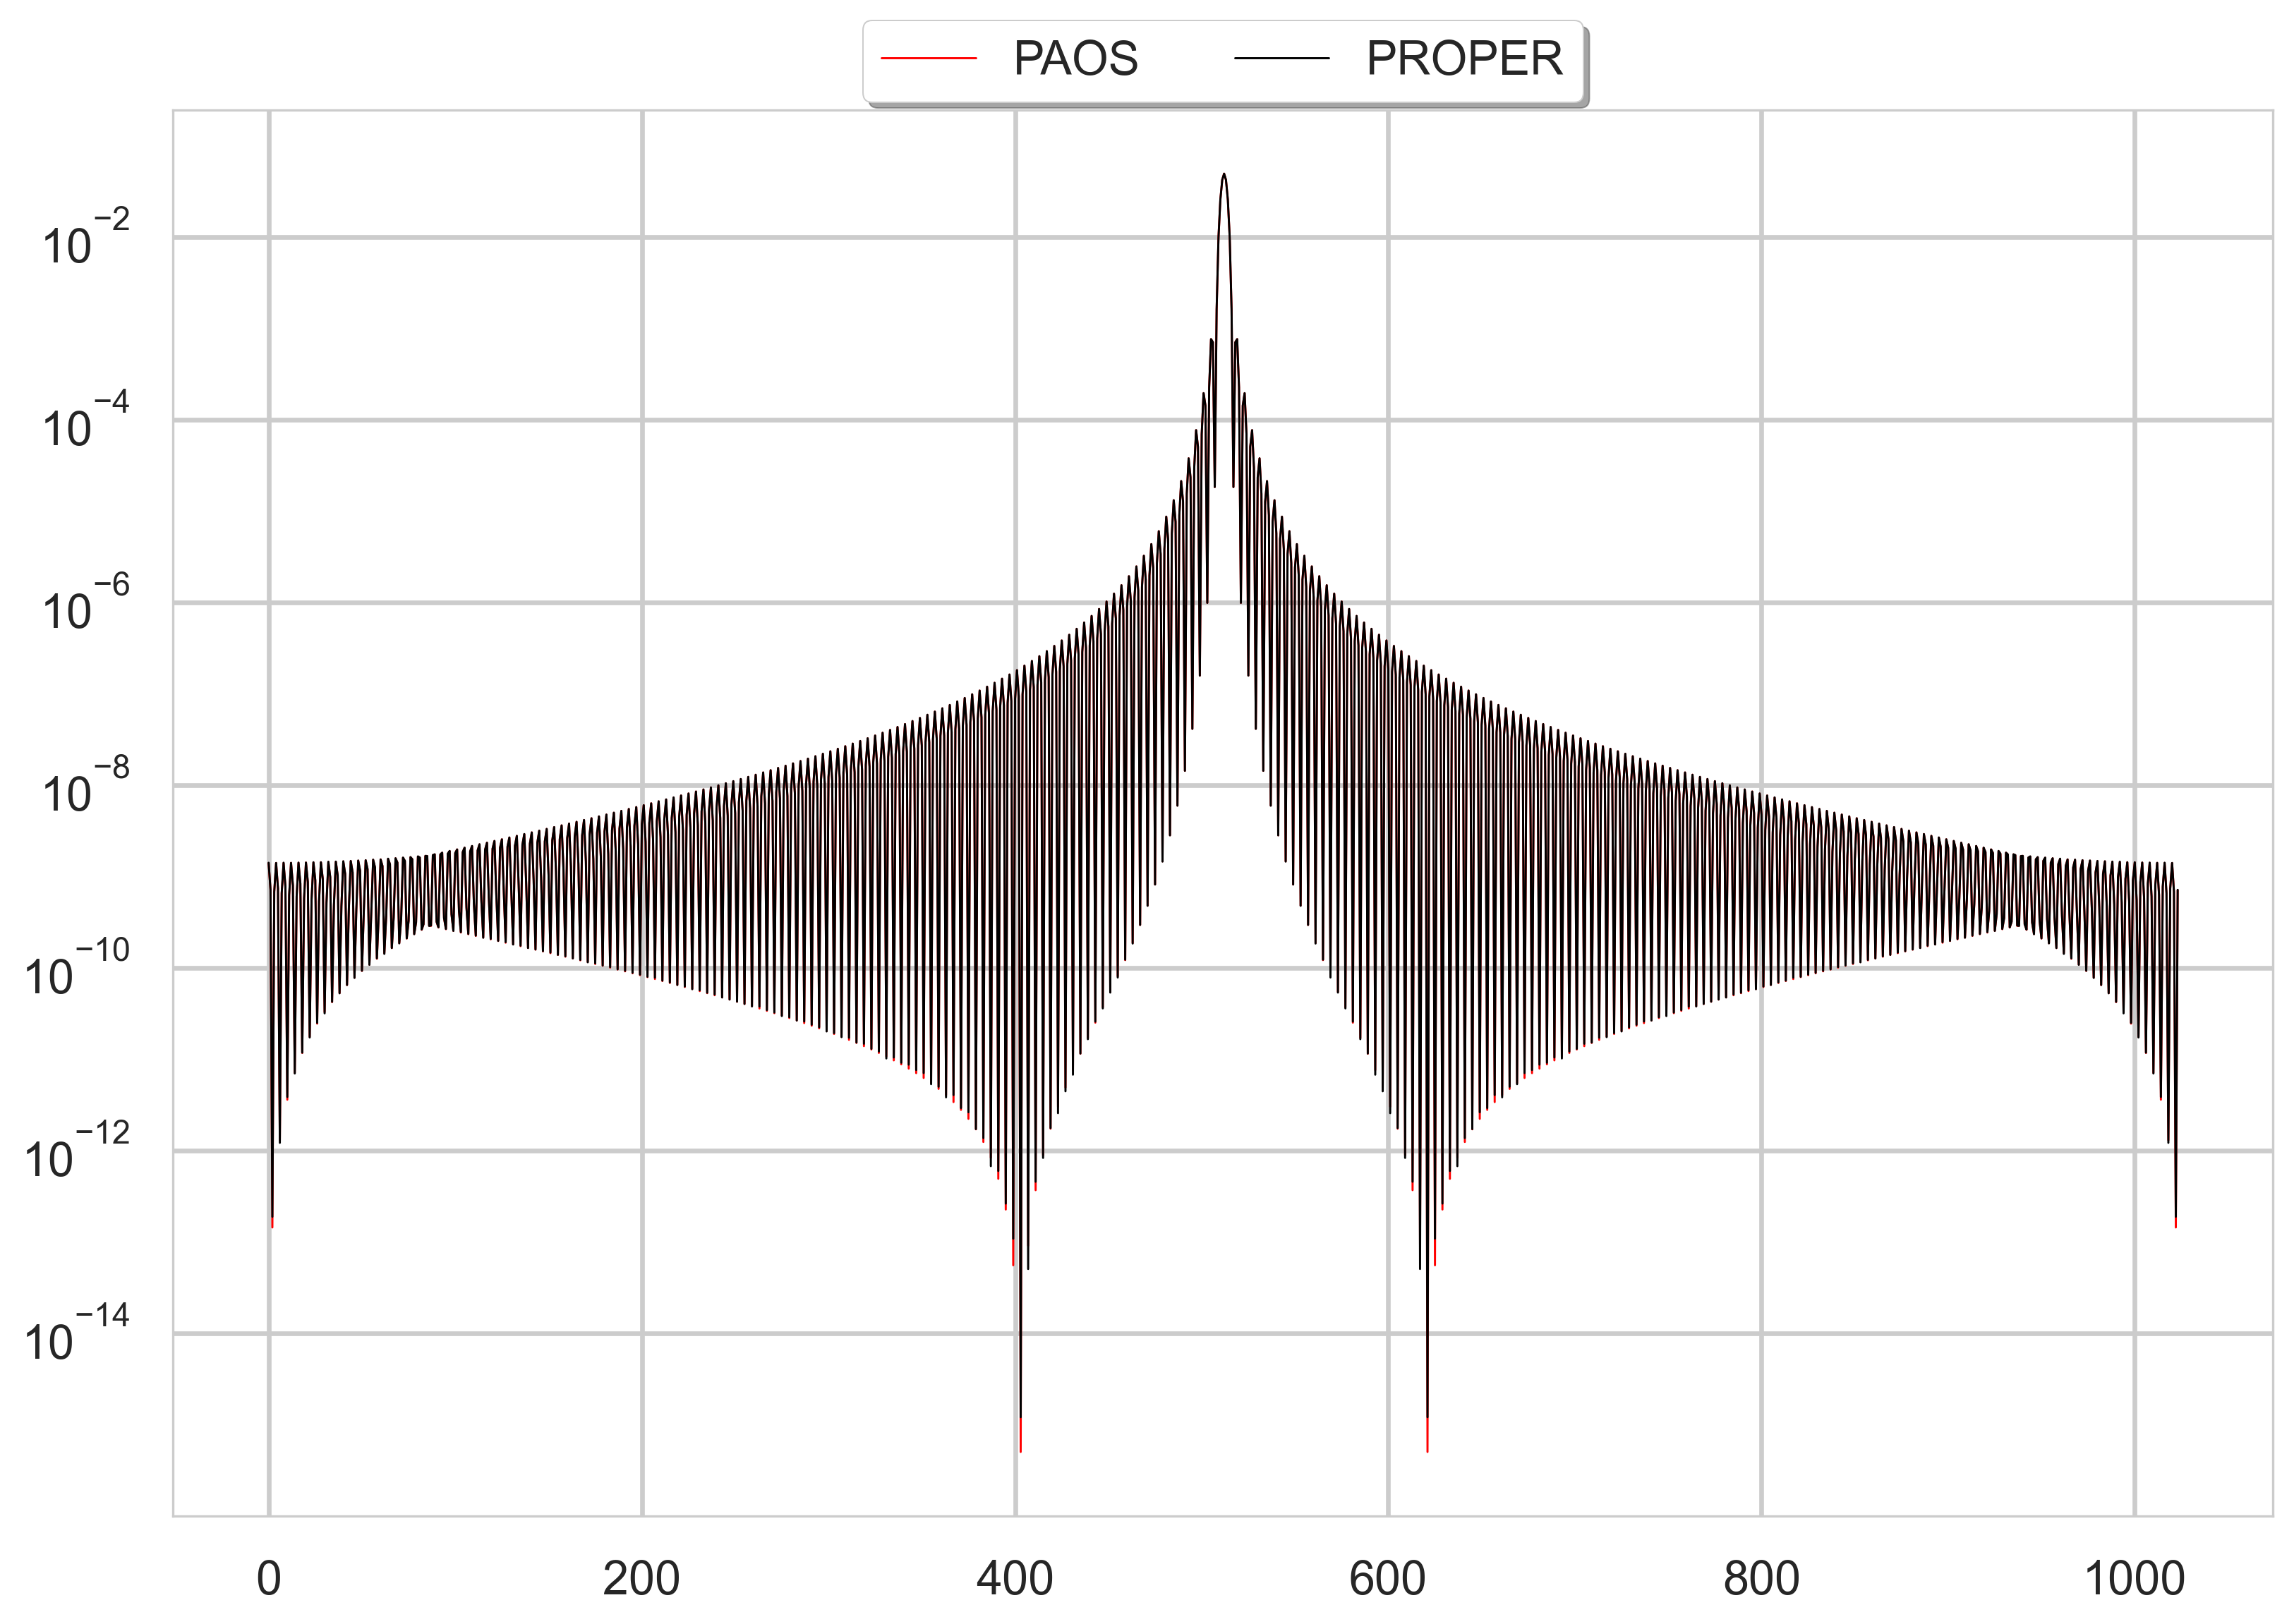

In [9]:
plt.figure(dpi=300)
plt.semilogy(paos_psf[paos_psf.shape[0] // 2, :], label='PAOS', lw=0.7, color='red')
plt.semilogy(proper_psf[proper_psf.shape[0] // 2, :], label='PROPER', lw=0.7, color='black')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.08),
             ncol=3, fancybox=True, shadow=True)
